In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method), PGD (Projected Gradient Descent) and UAP (Universal adversarial perturbations). To enhance your understanding, you will implement the PGD and UAP attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model.

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- UAP Attack from scratch
- Visualization
- Adversarial Training


Name: Amir Mohammad Ezzati

Student Number: 402212269

In [ ]:
!pip install torchattacks -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 11.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.25.0 requires requests>=2.27.1, but you have requests 2.25.1 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.25.1 which is incompatible.
tweepy 4.14.0 requires requests<3,>=2.27.0, but you have requests 2.25.1 which is incompatible.
yfinance 0.2.48 requires requests>=2.31, but you have req

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/SPML/'

Mounted at /content/drive


## Train Resnet on CIFAR10 (15 pts)

In [ ]:
# Prepare Cifar10 data
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
################################ End #########################################

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
# model architecture
class resnet(nn.Module):
  def __init__(self, num_cls):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits

##############################################################################
# Initialize model and move to device                                        #
##############################################################################

num_classes = 10
model = resnet(num_cls=num_classes)
model = model.to(device)

################################ End #########################################

In [ ]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [ ]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}")

################################ End #########################################

Epoch [1/100], Loss: 1.5277
Epoch [2/100], Loss: 1.1026
Epoch [3/100], Loss: 0.8992
Epoch [4/100], Loss: 0.7505
Epoch [5/100], Loss: 0.6314
Epoch [6/100], Loss: 0.5239
Epoch [7/100], Loss: 0.4372
Epoch [8/100], Loss: 0.3634
Epoch [9/100], Loss: 0.2876
Epoch [10/100], Loss: 0.2404
Epoch [11/100], Loss: 0.1874
Epoch [12/100], Loss: 0.1717
Epoch [13/100], Loss: 0.1399
Epoch [14/100], Loss: 0.1138
Epoch [15/100], Loss: 0.0903
Epoch [16/100], Loss: 0.0886
Epoch [17/100], Loss: 0.0669
Epoch [18/100], Loss: 0.0759
Epoch [19/100], Loss: 0.0587
Epoch [20/100], Loss: 0.0554
Epoch [21/100], Loss: 0.0502
Epoch [22/100], Loss: 0.0430
Epoch [23/100], Loss: 0.0392
Epoch [24/100], Loss: 0.0308
Epoch [25/100], Loss: 0.0278
Epoch [26/100], Loss: 0.0262
Epoch [27/100], Loss: 0.0288
Epoch [28/100], Loss: 0.0317
Epoch [29/100], Loss: 0.0310
Epoch [30/100], Loss: 0.0270
Epoch [31/100], Loss: 0.0277
Epoch [32/100], Loss: 0.0205
Epoch [33/100], Loss: 0.0246
Epoch [34/100], Loss: 0.0153
Epoch [35/100], Loss: 0

In [50]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

################################ End #########################################

Test Accuracy: 74.93%


In [ ]:
# Save model
model.eval()
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = base_path + f"{model_name}"
torch.save(model.state_dict(), model_PATH)

In [47]:
model = resnet(num_cls=10).to(device)
model.load_state_dict(torch.load(base_path + "resnet18_cifar10_model_pretrained.pth", weights_only=True))

<All keys matched successfully>

## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [40]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################
import torchattacks


def fgsm(model, epsilon):
  model.eval()
  fgsm_attack = torchattacks.FGSM(model, eps=epsilon)

  correct = 0
  total = 0
  for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = fgsm_attack(inputs, labels)

    with torch.no_grad():
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f'Accuracy on FGSM Attack with epsilon={epsilon}: {accuracy:.2f}%')


epsilon = 1/255
fgsm(model, epsilon)

################################ End #########################################

Accuracy on FGSM Attack with epsilon=0.00392156862745098: 53.93%


In [61]:
##############################################################################
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #
##############################################################################

epsilon = 4/255
fgsm(model, epsilon)

################################ End #########################################

Accuracy on FGSM Attack with epsilon=0.01568627450980392: 24.15%


In [62]:
##############################################################################
# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #
##############################################################################

epsilon = 8/255
fgsm(model, epsilon)

################################ End #########################################

Accuracy on FGSM Attack with epsilon=0.03137254901960784: 11.93%


## PGD Attack from scratch (15 pts)

In this section you should implement PGD attack from scratch.

In [42]:
class LinfPGDAttack(object):

    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, image, label):

        image = image.to(device)
        label = label.to(device)

        out = self.model(image)
        _, pred = torch.max(out, 1)

        perturbed_image = image.clone()
        perturbed_image.to(device)

        if pred.item() == label.item():
            ##############################################################################
            # Implement a k step PGD attack of size alpha                                #
            # while always staying within epsilon distance from the initial point        #
            # Use cross entropy loss                                                     #
            ##############################################################################

            for _ in range(self.steps):
              perturbed_image = perturbed_image.detach()
              perturbed_image.requires_grad = True

              output = self.model(perturbed_image)

              self.model.zero_grad()
              loss = F.cross_entropy(output, label)
              loss.backward()

              perturbed_image = perturbed_image + self.alpha * perturbed_image.grad.sign()
              # Ensure the perturbation stays in range (-epsion, +epsilon)
              perturbed_image = torch.clamp(perturbed_image, image - self.epsilon, image + self.epsilon)
              # Clip to maintain valid image pixel range [0, 1]
              perturbed_image = torch.clamp(perturbed_image, 0, 1)

            ################################ End #########################################

        return perturbed_image

In [43]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2,4,8]

##############################################################################

def pgd(model, k):
  pgd_attack = LinfPGDAttack(model, k=k)

  correct = 0
  total = 0
  model.eval()

  for inputs, labels in testloader:
      inputs, labels = inputs.to(device), labels.to(device)

      # Generate adversarial examples using PGD
      adv_inputs = torch.stack([pgd_attack(img.unsqueeze(0), lbl.unsqueeze(0)).squeeze(0) for img, lbl in zip(inputs, labels)])

      with torch.no_grad():
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f'Accuracy on PGD Attack with k={k}: {accuracy:.2f}%')

for k in k_list:
  pgd(model, k)


################################ End #########################################

Accuracy on PGD Attack with k=2: 16.77%
Accuracy on PGD Attack with k=4: 2.94%
Accuracy on PGD Attack with k=8: 0.71%


## UAP Attack from scratch (15 pts)

In this section you should implement UAP attack from scratch.

In [54]:
class UAPAttack(object):

    def __init__(self, model, epsilon=8/255, delta=2/255, max_iters=10, data_loader=None):
        self.model = model
        self.epsilon = epsilon
        self.delta = delta
        self.max_iters = max_iters
        self.data_loader = data_loader

        # Initialize universal perturbation to zero
        self.uap = torch.zeros(1, 3, 32, 32).to(device) # size of CIFAR10 dataset sample

    def generate_uap(self):
        """
        Generate Universal Adversarial Perturbation (UAP) using the dataset.
        """
        for _ in range(self.max_iters):
            for images, labels in self.data_loader:
                images, labels = images.to(device), labels.to(device)

                # Add the current universal perturbation to the images
                perturbed_images = torch.clamp(images + self.uap, 0, 1)

                # Perform forward pass with perturbed images
                outputs = self.model(perturbed_images)
                _, preds = torch.max(outputs, 1)

                ##############################################################################
                # Implement misclassification logic                                          #
                # Find misclassified images and calculate the gradient                       #
                # Update the universal perturbation using the calculated gradient            #
                ##############################################################################

                # correctly classified images
                correct_indices = (preds == labels)
                correct_images = images[correct_indices]
                correct_labels = labels[correct_indices]

                if len(correct_images) == 0:
                    continue  # Skip if no correctly classified images

                # print(correct_images.shape)
                # print(self.uap.shape)
                perturbed_correct_images = torch.clamp(correct_images + self.uap, 0, 1)
                perturbed_correct_images.requires_grad = True

                outputs_correct = self.model(perturbed_correct_images)
                loss = F.cross_entropy(outputs_correct, correct_labels)

                self.model.zero_grad()
                loss.backward()

                avg_grad = perturbed_correct_images.grad.sign().mean(dim=0, keepdim=True)
                self.uap += self.delta * avg_grad

                ################################ End #########################################

                # Project the universal perturbation to the epsilon ball
                ##############################################################################
                # Implement projection logic to keep UAP within epsilon bounds               #
                ##############################################################################

                self.uap = torch.clamp(self.uap, -self.epsilon, self.epsilon)

                ################################ End #########################################

        self.uap = self.uap.detach()
        return self.uap

    def __call__(self, image):
        """
        Apply the universal perturbation to a given image.
        """
        image = image.to(device)
        perturbed_image = torch.clamp(image + self.uap, 0, 1)
        return perturbed_image

In [55]:
##############################################################################
# Evaluate UAP attack on the trained model with max_iters = 10               #
##############################################################################

max_iters = 10

##############################################################################

uap_attack = UAPAttack(model=model, epsilon=16/255, delta=2/255, max_iters=max_iters, data_loader=trainloader)
uap = uap_attack.generate_uap()

model.eval()
correct = 0
total = 0
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)

    adv_images = uap_attack(images)

    with torch.no_grad():
        outputs = model(adv_images)
        _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on UAP attack with max_iters={max_iters}: {accuracy:.2f}%')

################################ End #########################################

Accuracy on UAP attack with max_iters=10: 33.87%


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [ ]:
##############################################################################
# Implement the function described                                           #
##############################################################################

import matplotlib.pyplot as plt
import random
import torchvision.transforms as transforms


def plot_images(type_, original, perturbed, perturbation, true_label, adv_label):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original.permute(1, 2, 0).cpu().detach().numpy())
    axes[0].set_title(f"Original Image | Label: {true_label}")
    axes[1].imshow(perturbed.permute(1, 2, 0).cpu().detach().numpy())
    axes[1].set_title(f"Adversarial Image | Label: {adv_label}")
    for ax in axes:
        ax.axis("off")
    plt.suptitle(f"{type_} Attack on CIFAR10")
    plt.show()


def apply_attack(attack, attack_type='FGSM'):
  indices = random.sample(range(len(testset)), 3)

  for i in indices:
      image, label = testset[i]
      image = image.unsqueeze(0).to(device)  # add batch dimension
      label = torch.tensor([label]).to(device)

      # generate adversarial example
      if attack_type=='FGSM' or attack_type=='PGD':
        adv_image = attack(image, label)
      elif attack_type == 'UAP':
        adv_image = attack(image)

      # calculate perturbation
      perturbation = (adv_image - image)
      perturbation = torch.clamp(perturbation, 0, 1)  # Clamp for visualization purposes

      with torch.no_grad():
        adv_output = model(adv_image)
        _, adv_pred = torch.max(adv_output, 1)
        adv_label = classes[adv_pred.item()]

      plot_images(
          type_=attack_type,
          original=image.squeeze(0),  # remove batch dimension for visualization
          perturbed=adv_image.squeeze(0),
          perturbation=perturbation.squeeze(0),
          true_label=classes[label.item()],
          adv_label=adv_label
      )

################################ End #########################################

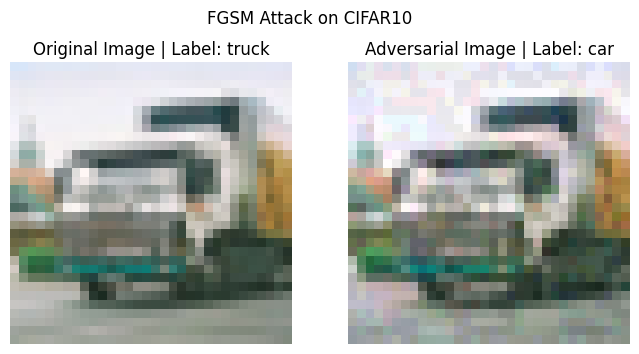

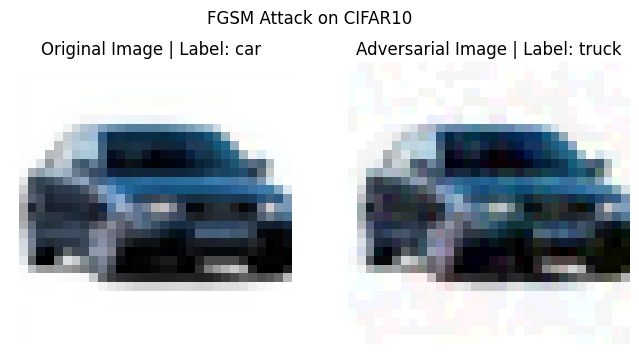

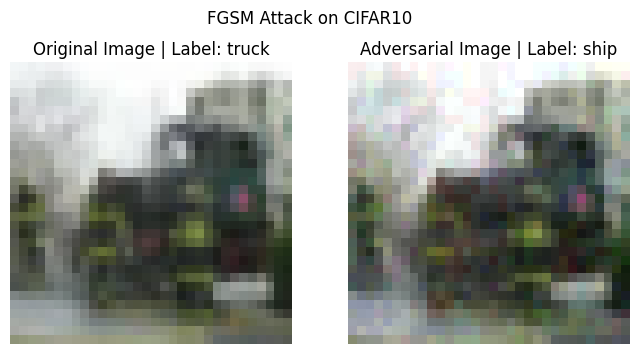

In [ ]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################

epsilon = 8 / 255
fgsm_attack = torchattacks.FGSM(model, eps=epsilon)

apply_attack(fgsm_attack, 'FGSM')

################################ End #########################################

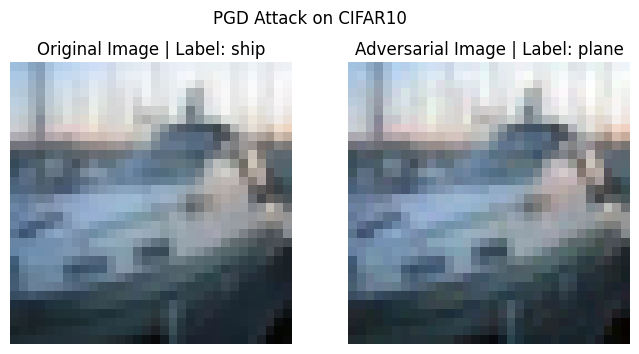

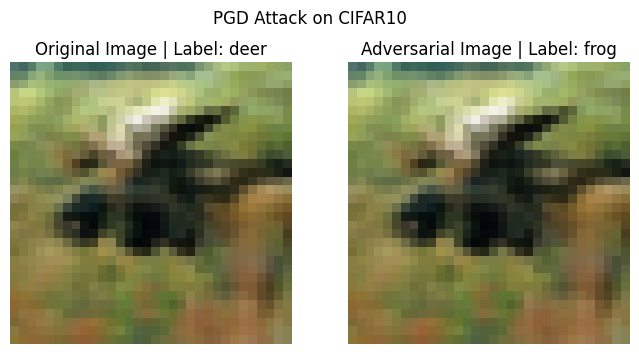

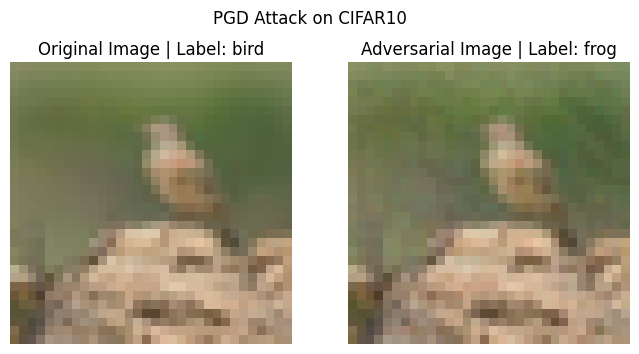

In [ ]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################

k = 2
pgd_attack = LinfPGDAttack(model, k=k)

apply_attack(pgd_attack, 'PGD')


################################ End #########################################

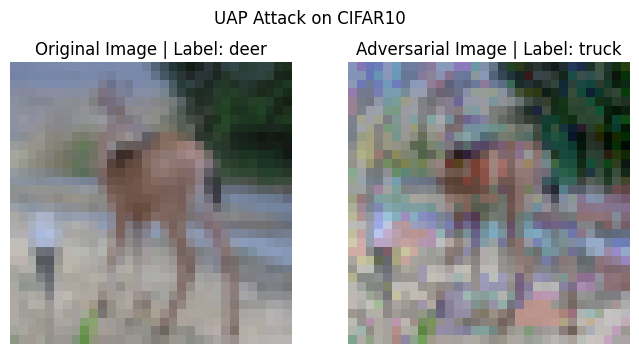

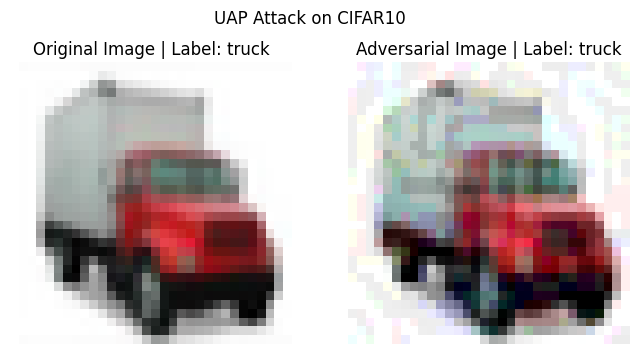

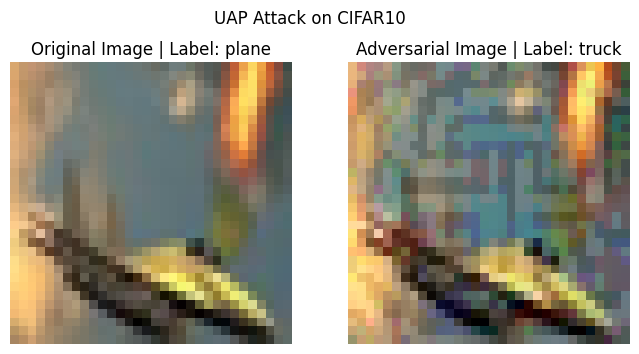

In [60]:
##############################################################################
# Choose 3 random images from testset and run UAP attack and visualize       #
##############################################################################

max_iters = 10
uap_attack = UAPAttack(model=model, epsilon=16/255, delta=2/255, max_iters=max_iters, data_loader=trainloader)
uap = uap_attack.generate_uap()

apply_attack(uap_attack, 'UAP')

################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results.

In [ ]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

adv_model = resnet(num_cls=len(classes))
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100


# Your code goes here
import torchattacks

epsilon = 8 / 255
fgsm_attack = torchattacks.FGSM(adv_model, eps=epsilon)

adv_model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        # generate adversarial examples using FGSM
        adv_images = fgsm_attack(images, labels)

        optimizer.zero_grad()
        outputs = adv_model(adv_images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}")


################################ End #########################################

Epoch [1/100], Loss: 2.118966
Epoch [2/100], Loss: 1.988659
Epoch [3/100], Loss: 1.923229
Epoch [4/100], Loss: 1.874565
Epoch [5/100], Loss: 1.834785
Epoch [6/100], Loss: 1.796549
Epoch [7/100], Loss: 1.768140
Epoch [8/100], Loss: 1.732278
Epoch [9/100], Loss: 1.699536
Epoch [10/100], Loss: 1.666784
Epoch [11/100], Loss: 1.634417
Epoch [12/100], Loss: 1.595821
Epoch [13/100], Loss: 1.558352
Epoch [14/100], Loss: 1.523706
Epoch [15/100], Loss: 1.482494
Epoch [16/100], Loss: 1.442727
Epoch [17/100], Loss: 1.404041
Epoch [18/100], Loss: 1.365894
Epoch [19/100], Loss: 1.323361
Epoch [20/100], Loss: 1.285826
Epoch [21/100], Loss: 1.244409
Epoch [22/100], Loss: 1.199258
Epoch [23/100], Loss: 1.160209
Epoch [24/100], Loss: 1.118489
Epoch [25/100], Loss: 1.086470
Epoch [26/100], Loss: 1.049969
Epoch [27/100], Loss: 1.019038
Epoch [28/100], Loss: 0.976112
Epoch [29/100], Loss: 0.946168
Epoch [30/100], Loss: 0.924567
Epoch [31/100], Loss: 0.883654
Epoch [32/100], Loss: 0.859573
Epoch [33/100], L

In [ ]:
adv_model.eval()
model_name = "resnet18_cifar10_adv_trained_model.pth"
model_PATH = base_path + f"{model_name}"
torch.save(adv_model.state_dict(), model_PATH)

In [57]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

adv_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = adv_model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

clean_accuracy = 100 * correct / total
print(f"Accuracy of the adversarially trained model on clean test images: {clean_accuracy:.2f}%")

################################ End #########################################

Accuracy of the adversarially trained model on clean test images: 61.11%


In [39]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################

# Your code goes here
epsilon = 8/255
fgsm(adv_model, epsilon)

################################ End #########################################

Accuracy on FGSM Attack with epsilon=0.03137254901960784: 24.38%


In [44]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

# Your code goes here
pgd(adv_model, k=4)

################################ End #########################################

Accuracy on PGD Attack with k=4: 20.03%


In [56]:
##############################################################################
#  Run UAP attack on the adversarially trained model with max_iters = 10     #
##############################################################################

uap_attack = UAPAttack(model=adv_model, epsilon=16/255, delta=2/255, max_iters=10, data_loader=trainloader)
uap = uap_attack.generate_uap()

adv_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        adv_images = uap_attack(images)

        outputs = adv_model(adv_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

uap_accuracy = 100 * correct / total
print(f"Accuracy on UAP Attack: {uap_accuracy:.2f}%")

################################ End #########################################

Accuracy on UAP Attack: 57.59%


Answer the following questions:
- What happened to the accuracy of the adversarially trained model?

  The adversarially trained model’s accuracy on clean data decreased from 74.93% to 61.11%. This drop is typical in adversarial training, where enhancing robustness to attacks often sacrifices performance on unperturbed data.
  The model’s accuracy on adversarial examples improved for FGSM (from 11.93% to 24.38%), PGD (from 2.94% to 20.03%), and UAP (from 33.87 to 57.59%), demonstrating that adversarial training has made the model more resilient to attacks.

- What do you conclude from the result of the FGSM attack on the adversarially trained model?

  The model’s resistance to FGSM attacks improved, with accuracy increasing from 11.93% to 24.38%. This indicates that adversarial training with FGSM helped the model recognize some adversarial examples generated using the same method, even if it still struggles to fully resist FGSM attacks.

- What do you conclude from the result of the PGD attack on the adversarially trained model?

  Adversarial training with FGSM provided some defensive benefit against PGD attacks, as accuracy improved from 2.94% to 20.03%. However, PGD attacks still significantly impact the model, reflecting their strength as a multi-step attack.


- What do you conclude from the result of the UAP attack on the adversarially trained model?

  The adversarially trained model showed a significant improvement in accuracy against UAP, from 33.87% to 57.59%. This shows that FGSM training has given the model some ability to resist generalized attacks across samples, like UAP. However, this result was obtained under a stronger perturbation (epsilon = 16/255).

- What is you final conclusion?

  Adversarial training with FGSM enhances model robustness to various types of adversarial attacks, including FGSM, PGD, and UAP, though the degree of resilience varies.

  There is a trade-off: improved robustness comes with a decrease in clean accuracy, seen here as a drop from 74.93% to 61.11%.